In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

In [6]:
# Load Processed Data
df = pd.read_csv("D:/Code_ML/dynamic_pricing_engine/data/processed/processed_data.csv")
df.shape

(18250, 19)

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18250 entries, 0 to 18249
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Product_ID          18250 non-null  object        
 1   Date                18250 non-null  datetime64[ns]
 2   Base_Cost           18250 non-null  float64       
 3   Price               18250 non-null  float64       
 4   Competitor_Price    18250 non-null  float64       
 5   Inventory           18250 non-null  int64         
 6   Units_Demanded      18250 non-null  int64         
 7   Competitor_Delta    18250 non-null  float64       
 8   Margin              18250 non-null  float64       
 9   Price_Cost_Ratio    18250 non-null  float64       
 10  Inventory_Pressure  18250 non-null  int64         
 11  Day_Week            18250 non-null  int64         
 12  Month               18250 non-null  int64         
 13  Week_Year           18250 non-null  int64         


In [10]:
# Time Based Train Test Split

df = df.sort_values(by=['Date'])
test_days = 60
last_date = df['Date'].max()
cutoff_date = last_date - pd.Timedelta(days=test_days)

train_df = df[df['Date'] <= cutoff_date].copy()
test_df = df[df['Date'] > cutoff_date].copy()

In [11]:
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (15250, 19), Test shape: (3000, 19)


In [15]:
# Select Features and Target

target = 'Units_Demanded'

exclude = ['Date', 'Product_ID', 'Units_Demanded']

features = [c for c in df.columns if c not in exclude]

In [17]:
print(features)
features[:40]

['Base_Cost', 'Price', 'Competitor_Price', 'Inventory', 'Competitor_Delta', 'Margin', 'Price_Cost_Ratio', 'Inventory_Pressure', 'Day_Week', 'Month', 'Week_Year', 'rolling_demand_7', 'rolling_demand_30', 'lag_1', 'lag_7', 'lag_30']


['Base_Cost',
 'Price',
 'Competitor_Price',
 'Inventory',
 'Competitor_Delta',
 'Margin',
 'Price_Cost_Ratio',
 'Inventory_Pressure',
 'Day_Week',
 'Month',
 'Week_Year',
 'rolling_demand_7',
 'rolling_demand_30',
 'lag_1',
 'lag_7',
 'lag_30']

In [19]:
# Train Test

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [20]:
# Ensure no inf/nans
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test  = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Clip negative targets (shouldn't be negative)
y_train = y_train.clip(lower=0)
y_test  = y_test.clip(lower=0)

In [34]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [35]:
from xgboost import XGBRegressor

In [38]:
model_xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="auto",  # if using GPU change to "gpu_hist"
)

In [40]:
model_xgb.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=50)

[0]	validation_0-rmse:28.31719	validation_1-rmse:28.03817
[50]	validation_0-rmse:17.93016	validation_1-rmse:18.16055
[100]	validation_0-rmse:14.92302	validation_1-rmse:15.62542
[150]	validation_0-rmse:12.52394	validation_1-rmse:13.73879
[200]	validation_0-rmse:10.69680	validation_1-rmse:12.36803
[250]	validation_0-rmse:9.32568	validation_1-rmse:11.42144
[299]	validation_0-rmse:8.22485	validation_1-rmse:10.71188


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [42]:
preds = model_xgb.predict(X_test).clip(0)
mae  = mean_absolute_error(y_test, preds)
r2   = r2_score(y_test, preds)


print(f"MAE : {mae:.3f}")
print(f"R2  : {r2:.3f}")

MAE : 7.894
R2  : 0.849


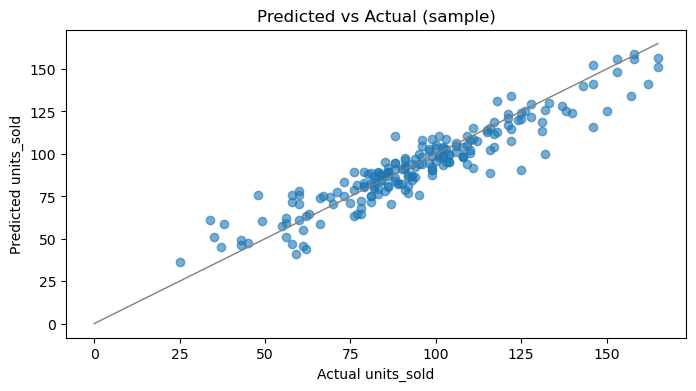

In [44]:
import matplotlib.pyplot as plt

# Take a random sample for plotting (or a single product timeline)
sample = test_df.sample(200, random_state=1).copy()
sample["preds"] = model_xgb.predict(sample[features]).clip(0)

plt.figure(figsize=(8,4))
plt.scatter(sample["Units_Demanded"], sample["preds"], alpha=0.6)
plt.xlabel("Actual units_sold")
plt.ylabel("Predicted units_sold")
plt.title("Predicted vs Actual (sample)")
plt.plot([0, max(sample["Units_Demanded"].max(), sample["preds"].max())],
         [0, max(sample["Units_Demanded"].max(), sample["preds"].max())], color="gray", linewidth=1)
plt.show()

In [45]:
# Feature Importance

fi = model_xgb.get_booster().get_score(importance_type="gain")
fi_sorted = sorted(fi.items(), key=lambda x: x[1], reverse=True)
fi_sorted[:20]

[('Competitor_Delta', 14525.90234375),
 ('rolling_demand_7', 13324.037109375),
 ('Price_Cost_Ratio', 6790.74365234375),
 ('Margin', 6645.46435546875),
 ('Price', 5591.86328125),
 ('Base_Cost', 5021.78759765625),
 ('Competitor_Price', 2917.23583984375),
 ('Week_Year', 2708.294189453125),
 ('rolling_demand_30', 2225.343017578125),
 ('lag_1', 1982.478759765625),
 ('Month', 1830.062744140625),
 ('lag_7', 907.4478149414062),
 ('lag_30', 885.6145629882812),
 ('Inventory', 641.4467163085938),
 ('Day_Week', 579.2208251953125),
 ('Inventory_Pressure', 502.9242248535156)]

In [46]:
fi_df = pd.DataFrame(fi_sorted, columns=["feature", "gain"])
fi_df.head(20)

,feature,gain
0,Competitor_Delta,14525.902344
1,rolling_demand_7,13324.037109
2,Price_Cost_Ratio,6790.743652
3,Margin,6645.464355
4,Price,5591.863281
5,Base_Cost,5021.787598
6,Competitor_Price,2917.235840
7,Week_Year,2708.294189
8,rolling_demand_30,2225.343018
9,lag_1,1982.478760


In [47]:
# Save Model + Feature List

os.makedirs("D:/Code_ML/dynamic_pricing_engine/models", exist_ok=True)


In [48]:
joblib.dump(model_xgb, "../models/xgb_demand_model.pkl")
joblib.dump(features, "../models/feature_list.pkl")
print("Model and feature list saved.")

Model and feature list saved.


In [49]:
# Quick Sanity Check

m2 = joblib.load("../models/xgb_demand_model.pkl")
f2 = joblib.load("../models/feature_list.pkl")

assert f2 == features, "Feature lists do not match!"
print("Sanity check passed. Feature lists match.")

Sanity check passed. Feature lists match.


In [50]:
#EOF